In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

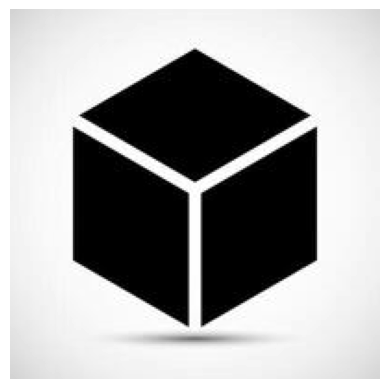

Dimenzije slike: (200, 200)


In [4]:
img = Image.open("data/exemple.jpg").convert("L")  # "L" = grayscale

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

img_array = np.array(img)
print("Dimenzije slike:", img_array.shape)


In [6]:
binary_matrix = np.where(img_array < 128, 1, 0)


print(binary_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
rectangles = []


